# First trimester cell type annotation

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd

In [2]:
adata = ad.read_h5ad('./vt_15.04.h5ad')

In [3]:
sc.tl.leiden(adata, flavor="igraph", resolution=0.6, n_iterations=2)

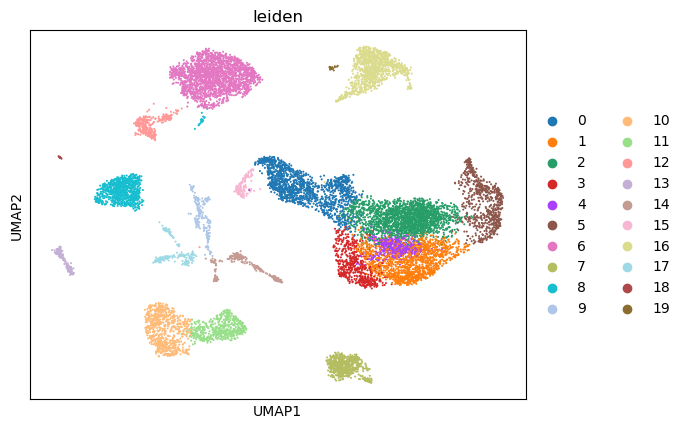

In [4]:
sc.pl.umap(adata, color=["leiden"])

In [5]:
sc.tl.paga(adata, groups='leiden')

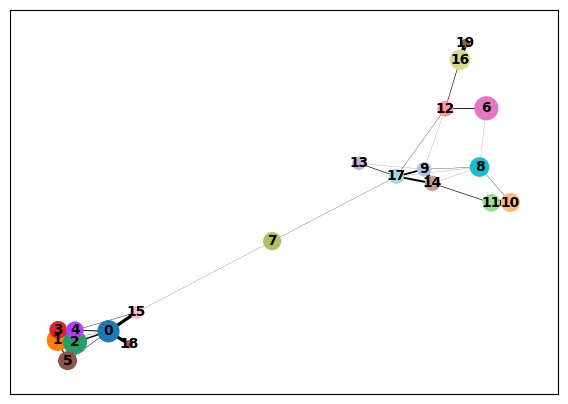

In [6]:
sc.pl.paga(adata, plot=True)

In [7]:
sc.tl.umap(adata, min_dist=0.7, spread=0.8, init_pos='paga')

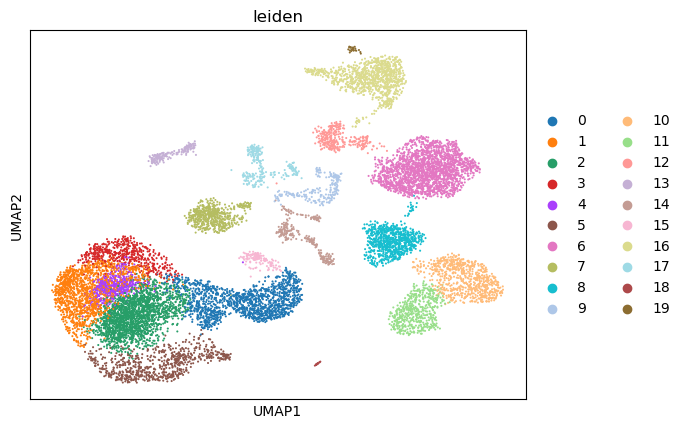

In [8]:
sc.pl.umap(adata, color='leiden')

#### Cell type annotation

In [9]:
# rank marker genes for each Leiden cluster
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon", key_added="wilcoxon")

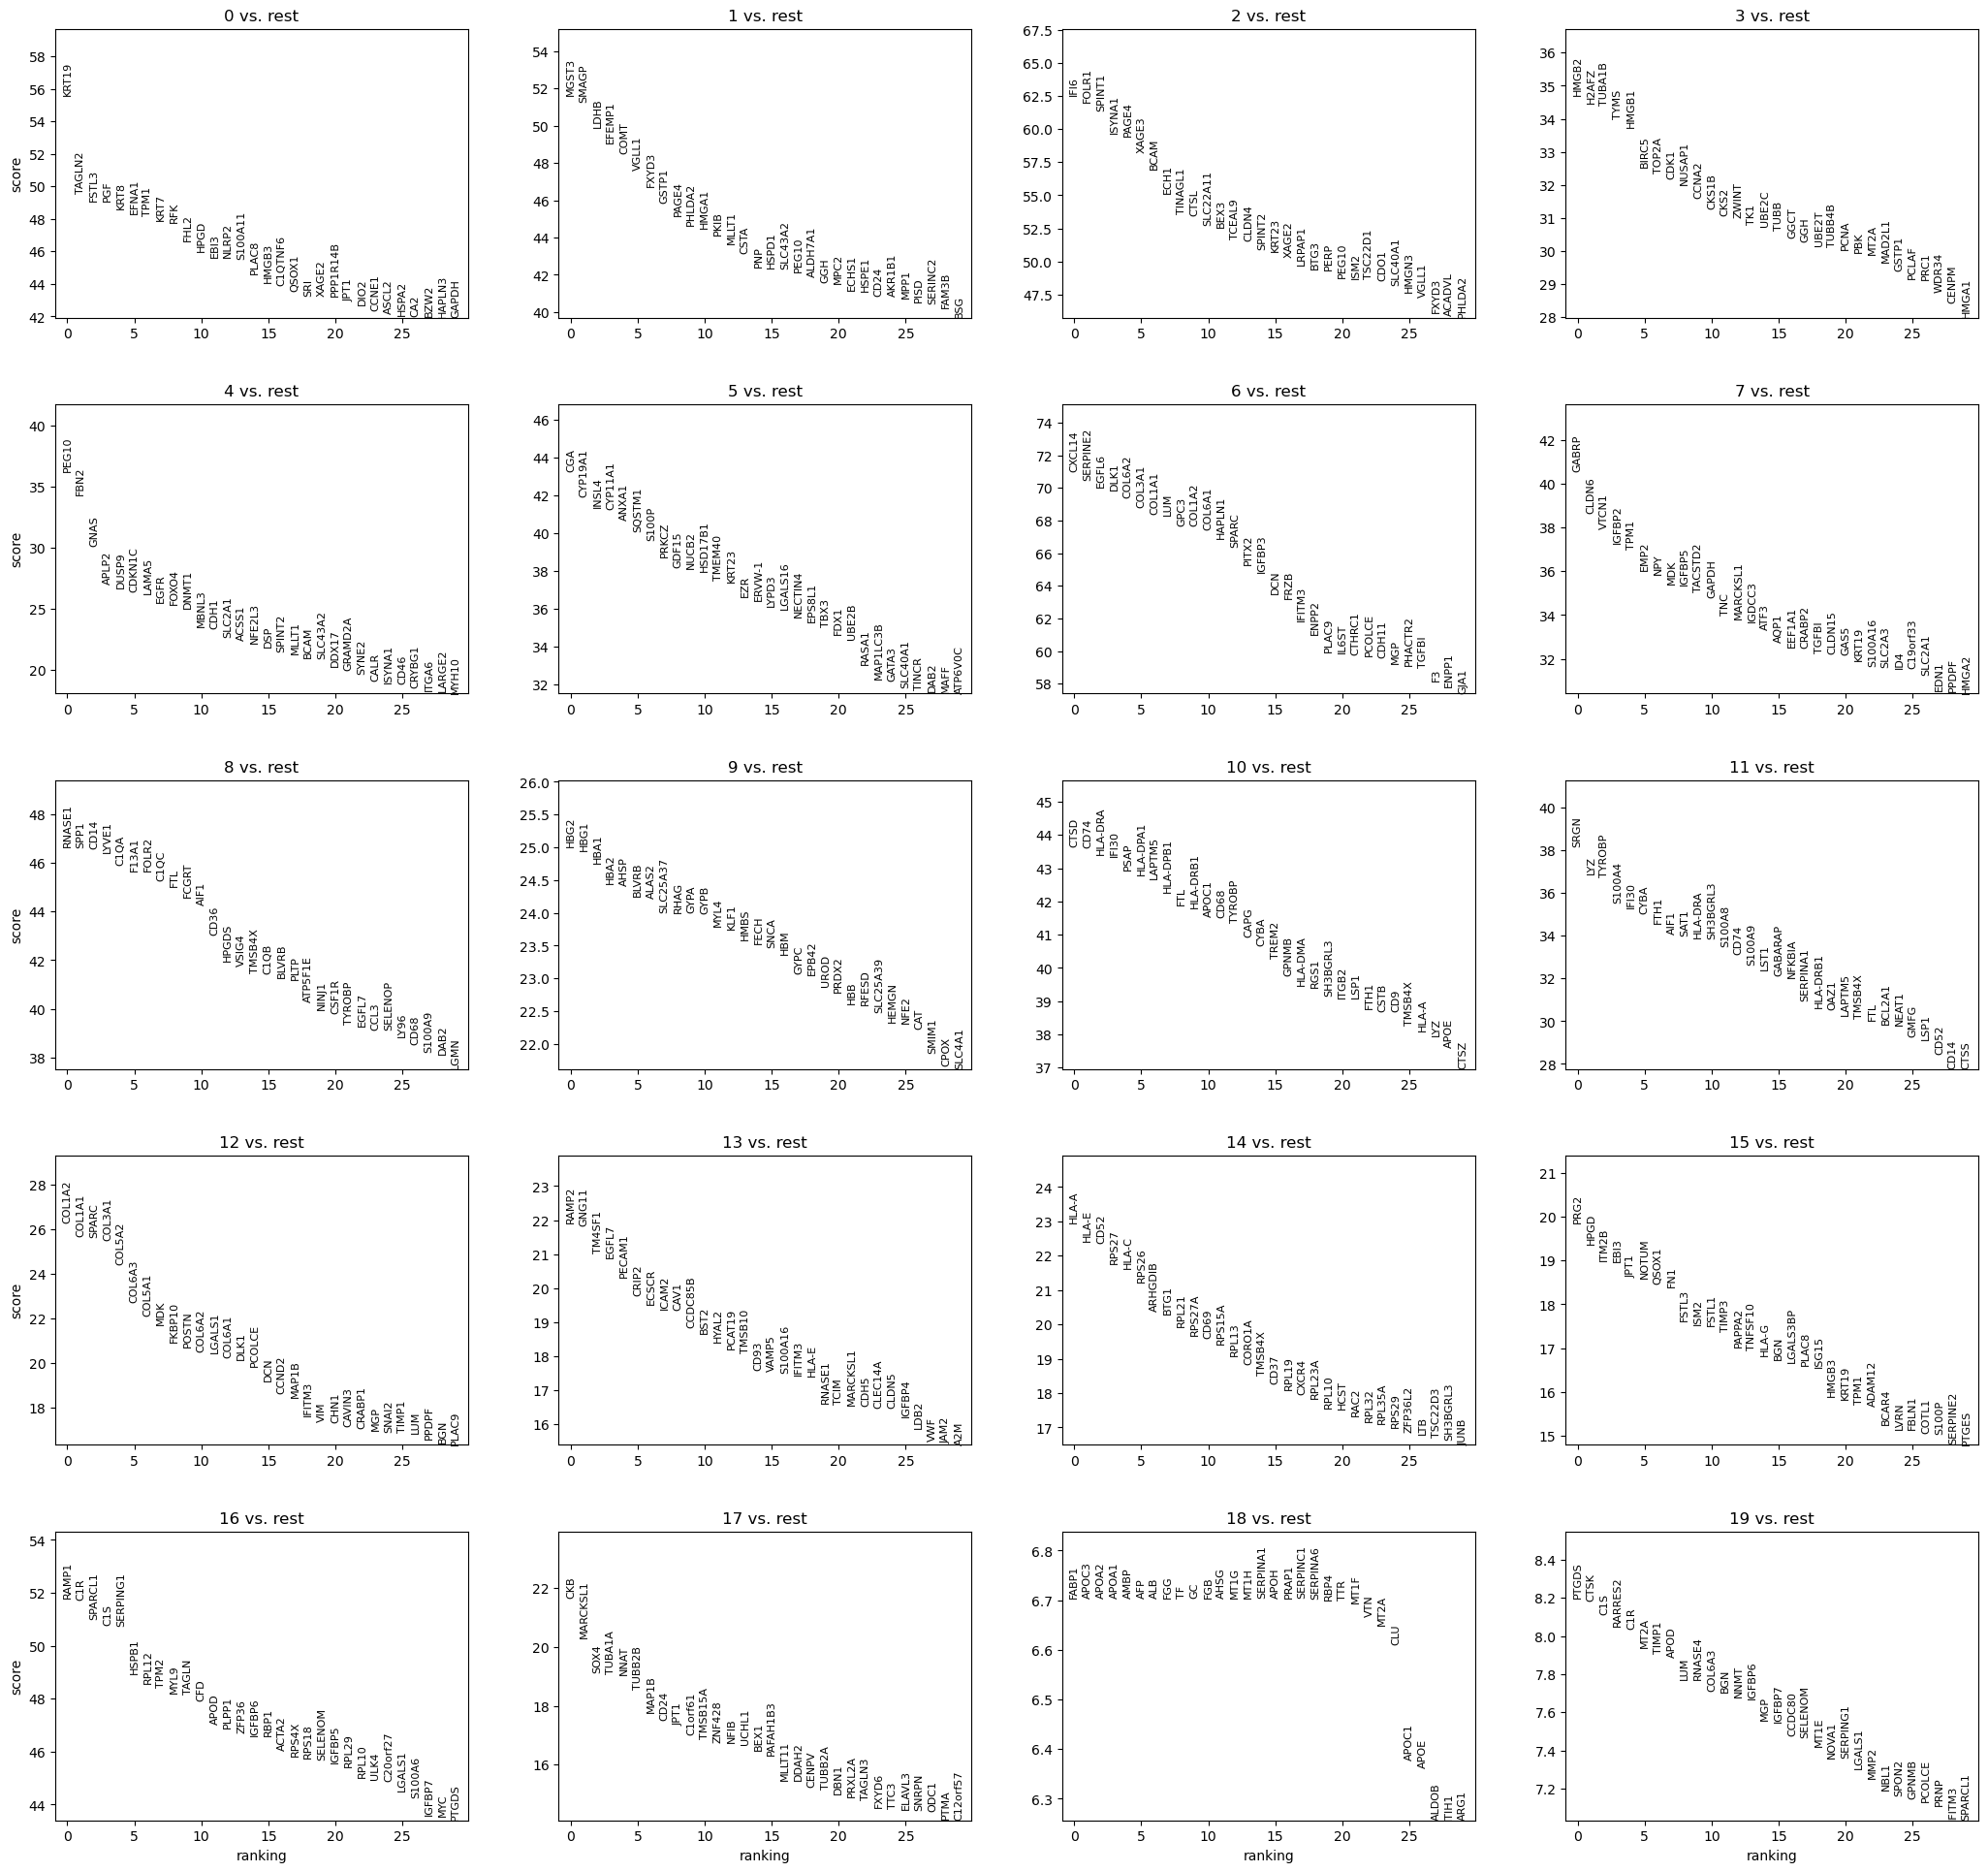

In [10]:
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False, key="wilcoxon")

In [11]:
# save marker genes for each cluster to a CSV file:

result = adata.uns['wilcoxon']
groups = result['names'].dtype.names # Get Leiden cluster names
# Create a DataFrame with marker gene names, p-values, and log fold changes
adata_genes= pd.DataFrame(
    {group +'_' +key[:1]:result[key][group]
     for group in groups for key in ['names', 'pvals', 'logfoldchanges']})

adata_genes.head()

,0_n,0_p,0_l,1_n,1_p,1_l,2_n,2_p,2_l,3_n,...,16_l,17_n,17_p,17_l,18_n,18_p,18_l,19_n,19_p,19_l
0,KRT19,0.0,4.049357,MGST3,0.0,2.559088,IFI6,0.0,3.474580,HMGB2,...,7.173841,CKB,6.101823e-104,5.596940,FABP1,2.024611e-11,13.929728,PTGDS,2.438349e-16,7.063008
1,TAGLN2,0.0,2.394757,SMAGP,0.0,3.645055,FOLR1,0.0,4.059217,H2AFZ,...,6.085210,MARCKSL1,1.172989e-91,5.006263,APOC3,2.024611e-11,13.972729,CTSK,2.712506e-16,6.274733
2,FSTL3,0.0,4.728964,LDHB,0.0,2.351735,SPINT1,0.0,3.463210,TUBA1B,...,7.852436,SOX4,1.892733e-81,4.560105,APOA2,2.024611e-11,12.756054,C1S,4.987615e-16,5.715096
3,PGF,0.0,3.839960,EFEMP1,0.0,3.213996,ISYNA1,0.0,3.329347,TYMS,...,6.129108,TUBA1A,2.905597e-81,5.171117,APOA1,2.024611e-11,13.347300,RARRES2,8.183124e-16,5.331053
4,KRT8,0.0,3.075645,COMT,0.0,2.380518,PAGE4,0.0,4.608173,HMGB1,...,4.485042,NNAT,6.327971e-81,7.661694,AMBP,2.024611e-11,13.858231,C1R,9.423022e-16,5.581608


In [12]:
adata_genes.to_csv('./vt.15.04.markergenes.csv')

In [13]:
# Define a function to map genes to cell types; uses Protein Atlas dataset to search for each marker gene and retrieve the top 3 cell types the gene is highly expressed in (based on nTPM values)
def gene_lookup(input_df, search_df):
    '''
    input_df: pandas dataframe with columns of different clusters, and rows containing gene names
    search_df: pandas dataframe containing the 'rna_single_cell_type_tissue.tsv' from human protein atlas (create a subset by tissue type)
    '''
    
    input_clusters = input_df.columns.tolist()
    output = []
    for cluster in input_clusters:  
        for gene in input_df[cluster].tolist():
            try:
                search = search_df[search_df['Gene name'] == gene].nlargest(3,'nTPM')
                output.append([cluster, gene, search['Cell type'].iloc[0],search['nTPM'].iloc[0],search['Cell type'].iloc[1],search['nTPM'].iloc[1],search['Cell type'].iloc[2],search['nTPM'].iloc[2]])
            except IndexError:
                output.append([cluster, gene, 'error', 'error', 'error', 'error', 'error', 'error'])
    return pd.DataFrame(output, columns = ['Cluster_Name', 'Gene_Name', 'Cell_Type_1', 'nTPM_1', 'Cell_Type_2', 'nTPM_2', 'Cell_Type_3', 'nTPM_3'])

In [14]:
# Load the Protein Atlas data
df = pd.read_csv('./rna_single_cell_type_tissue.tsv', sep='\t')
placenta_df = df[df['Tissue'] == 'placenta'].copy() # create a dataframe of genes where the Tissue type is 'placenta'
df = None
placenta_df.head()

,Gene,Gene name,Tissue,Cluster,Cell type,Read count,nTPM
86,ENSG00000000003,TSPAN6,placenta,c-0,cytotrophoblasts,1254,25.7
87,ENSG00000000003,TSPAN6,placenta,c-1,smooth muscle cells,857,54.3
88,ENSG00000000003,TSPAN6,placenta,c-2,extravillous trophoblasts,1624,48.7
89,ENSG00000000003,TSPAN6,placenta,c-3,cytotrophoblasts,882,33.3
90,ENSG00000000003,TSPAN6,placenta,c-4,hofbauer cells,33,2.7


In [15]:
 # Load the marker gene data into a pandas DataFrame
gene_to_cell_type_annotations = pd.read_csv('./vt.15.04.markergenes.csv',index_col=0)
gene_to_cell_type_annotations.head()

,0_n,0_p,0_l,1_n,1_p,1_l,2_n,2_p,2_l,3_n,...,16_l,17_n,17_p,17_l,18_n,18_p,18_l,19_n,19_p,19_l
0,KRT19,0.0,4.049357,MGST3,0.0,2.559088,IFI6,0.0,3.474580,HMGB2,...,7.173840,CKB,6.101823e-104,5.596940,FABP1,2.024611e-11,13.929728,PTGDS,2.438349e-16,7.063008
1,TAGLN2,0.0,2.394757,SMAGP,0.0,3.645055,FOLR1,0.0,4.059217,H2AFZ,...,6.085210,MARCKSL1,1.172989e-91,5.006263,APOC3,2.024611e-11,13.972729,CTSK,2.712506e-16,6.274733
2,FSTL3,0.0,4.728964,LDHB,0.0,2.351735,SPINT1,0.0,3.463210,TUBA1B,...,7.852436,SOX4,1.892733e-81,4.560105,APOA2,2.024611e-11,12.756054,C1S,4.987615e-16,5.715096
3,PGF,0.0,3.839960,EFEMP1,0.0,3.213996,ISYNA1,0.0,3.329347,TYMS,...,6.129108,TUBA1A,2.905597e-81,5.171117,APOA1,2.024611e-11,13.347300,RARRES2,8.183124e-16,5.331053
4,KRT8,0.0,3.075645,COMT,0.0,2.380518,PAGE4,0.0,4.608173,HMGB1,...,4.485042,NNAT,6.327971e-81,7.661694,AMBP,2.024611e-11,13.858231,C1R,9.423022e-16,5.581608


In [16]:
# Keep columns and first 30 genes for annotation
gene_to_cell_type_annotations = gene_to_cell_type_annotations.loc[:,gene_to_cell_type_annotations.columns].head(30).copy() 
gene_to_cell_type_annotations

,0_n,0_p,0_l,1_n,1_p,1_l,2_n,2_p,2_l,3_n,...,16_l,17_n,17_p,17_l,18_n,18_p,18_l,19_n,19_p,19_l
0,KRT19,0.0,4.049357,MGST3,0.0,2.559088,IFI6,0.0,3.474580,HMGB2,...,7.173840,CKB,6.101823e-104,5.596940,FABP1,2.024611e-11,13.929728,PTGDS,2.438349e-16,7.063008
1,TAGLN2,0.0,2.394757,SMAGP,0.0,3.645055,FOLR1,0.0,4.059217,H2AFZ,...,6.085210,MARCKSL1,1.172989e-91,5.006263,APOC3,2.024611e-11,13.972729,CTSK,2.712506e-16,6.274733
2,FSTL3,0.0,4.728964,LDHB,0.0,2.351735,SPINT1,0.0,3.463210,TUBA1B,...,7.852436,SOX4,1.892733e-81,4.560105,APOA2,2.024611e-11,12.756054,C1S,4.987615e-16,5.715096
3,PGF,0.0,3.839960,EFEMP1,0.0,3.213996,ISYNA1,0.0,3.329347,TYMS,...,6.129108,TUBA1A,2.905597e-81,5.171117,APOA1,2.024611e-11,13.347300,RARRES2,8.183124e-16,5.331053
4,KRT8,0.0,3.075645,COMT,0.0,2.380518,PAGE4,0.0,4.608173,HMGB1,...,4.485042,NNAT,6.327971e-81,7.661694,AMBP,2.024611e-11,13.858231,C1R,9.423022e-16,5.581608
5,EFNA1,0.0,3.104027,VGLL1,0.0,2.883239,XAGE3,0.0,3.451369,BIRC5,...,3.761814,TUBB2B,7.301625e-77,8.946436,AFP,2.024611e-11,13.907642,MT2A,2.002415e-15,5.662816
6,TPM1,0.0,3.178479,FXYD3,0.0,2.910210,BCAM,0.0,3.257538,TOP2A,...,1.591520,MAP1B,1.037498e-70,4.911080,ALB,2.024611e-11,14.215822,TIMP1,2.619061e-15,5.136698
7,KRT7,0.0,3.165259,GSTP1,0.0,1.466781,ECH1,0.0,2.157234,CDK1,...,4.456620,CD24,1.069957e-68,2.662360,FGG,2.024611e-11,13.807074,APOD,3.044156e-15,6.336102
8,RFK,0.0,3.099164,PAGE4,0.0,4.318708,TINAGL1,0.0,2.849849,NUSAP1,...,4.594164,JPT1,2.515152e-67,2.619543,TF,2.024611e-11,12.769882,LUM,7.648883e-15,5.936622
9,FHL2,0.0,2.600334,PHLDA2,0.0,3.384850,CTSL,0.0,2.248949,CCNA2,...,5.782171,C1orf61,7.735445e-65,9.062233,GC,2.024611e-11,14.379839,RNASE4,7.856538e-15,4.420047


In [17]:
# Maps marker genes to cell types by calling gene_lookup()
results = gene_lookup(gene_to_cell_type_annotations, placenta_df) 
results

,Cluster_Name,Gene_Name,Cell_Type_1,nTPM_1,Cell_Type_2,nTPM_2,Cell_Type_3,nTPM_3
0,0_n,KRT19,extravillous trophoblasts,9910.9,extravillous trophoblasts,8935.6,extravillous trophoblasts,7525.6
1,0_n,TAGLN2,extravillous trophoblasts,3503.6,extravillous trophoblasts,2852.8,extravillous trophoblasts,2755.0
2,0_n,FSTL3,extravillous trophoblasts,4841.4,extravillous trophoblasts,3849.5,syncytiotrophoblasts,730.9
3,0_n,PGF,syncytiotrophoblasts,2216.7,extravillous trophoblasts,1930.1,extravillous trophoblasts,1860.8
4,0_n,KRT8,extravillous trophoblasts,6892.0,extravillous trophoblasts,6314.1,cytotrophoblasts,6166.7
...,...,...,...,...,...,...,...,...
1795,19_l,3.476409,error,error,error,error,error,error
1796,19_l,3.970595,error,error,error,error,error,error
1797,19_l,3.238918,error,error,error,error,error,error
1798,19_l,3.318231,error,error,error,error,error,error


In [18]:
results.to_csv('./vt.15.04.markergenes_to _cell_type_annotation.csv') # used to manually assess cell type annotation

In [19]:
# create a dictionary to map cluster to annotation label
celltype = {
     '0': 'EVT',
     '1': 'CTB', 
     '2': 'CTB',
     '3': 'CTB', #?
     '4': 'CTB', #?
     '5': 'STB',
     '6': 'SM',
     '7': 'FB',
     '8': 'HB',
     '9': 'MIC',
    '10': 'HB',
    '11': 'HB', 
    '12': 'SM', #?
    '13': 'END',
    '14': 'MIC', #?
    '15': 'EVT',
    '16': 'SM',
    '17': 'MIC',
    '18': 'MIC',
    '19': 'SM'
}

# add a new `.obs` column called `cell_type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell_type'] = adata.obs['leiden'].map(celltype).astype('category')

In [20]:
# create a dictionary to map cluster to annotation label
uniquecelltype = {
     '0': 'EVT_1',
     '1': 'CTB_1', 
     '2': 'CTB_2',
     '3': 'CTB_3', #?
     '4': 'CTB_4', #?
     '5': 'STB_1',
     '6': 'SM_1',
     '7': 'FB_1',
     '8': 'HB_1',
     '9': 'MIC_1',
    '10': 'HB_2',
    '11': 'HB_3', 
    '12': 'SM_2', #?
    '13': 'END_1',
    '14': 'MIC_2', #?
    '15': 'EVT_2',
    '16': 'SM_3',
    '17': 'MIC_3',
    '18': 'MIC_4',
    '19': 'SM_4'
}

# add a new `.obs` column called `unique_cell_type` by mapping clusters to annotation using pandas `map` function
adata.obs['unique_cell_type'] = adata.obs['leiden'].map(uniquecelltype).astype('category')

In [21]:
adata.obs

,Sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,doublet_score,predicted_doublet,leiden,cell_type,unique_cell_type
CellID,,,,,,,,,,,,,,,,,,
FCA7196220:AAAGCAATCAGGCGAAx,FCA7196220,2622,7.872074,9926.0,9.203013,29.750151,41.255289,53.556317,69.514407,0.0,0.0,0.0,2619,0.013628,False,0,EVT,EVT_1
FCA7196220:AAATGCCTCAATCACGx,FCA7196220,1899,7.549609,4953.0,8.507951,27.054311,38.683626,50.555219,67.898243,0.0,0.0,0.0,1899,0.106838,False,1,CTB,CTB_1
FCA7196220:AAATGCCTCATACGGTx,FCA7196220,1259,7.138867,3235.0,8.082093,31.622875,42.472952,56.136012,76.537867,0.0,0.0,0.0,1259,0.013145,False,5,STB,STB_1
FCA7196220:AACACGTAGTGCCATTx,FCA7196220,1244,7.126891,2581.0,7.856319,28.826036,40.061991,52.963967,71.173964,0.0,0.0,0.0,1244,0.051186,False,6,SM,SM_1
FCA7196220:AAAGTAGTCCTGCTTGx,FCA7196220,822,6.712956,1982.0,7.592366,44.399596,54.036327,66.094854,83.753784,0.0,0.0,0.0,821,0.044571,False,5,STB,STB_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FCA7511884:TTGCGTCTCAGCCTAAx,FCA7511884,1139,7.038784,3185.0,8.066522,32.935636,46.405024,60.094192,79.937206,0.0,0.0,0.0,1139,0.020992,False,3,CTB,CTB_3
FCA7511884:TTGGCAATCCGCATCTx,FCA7511884,2474,7.813996,13528.0,9.512590,42.489651,58.685689,68.901538,80.093140,0.0,0.0,0.0,2472,0.056291,False,16,SM,SM_3
FCA7511884:TTGCCGTTCACTCTTAx,FCA7511884,2135,7.666690,9390.0,9.147507,46.368477,55.750799,65.985091,78.732694,0.0,0.0,0.0,2135,0.006289,False,8,HB,HB_1


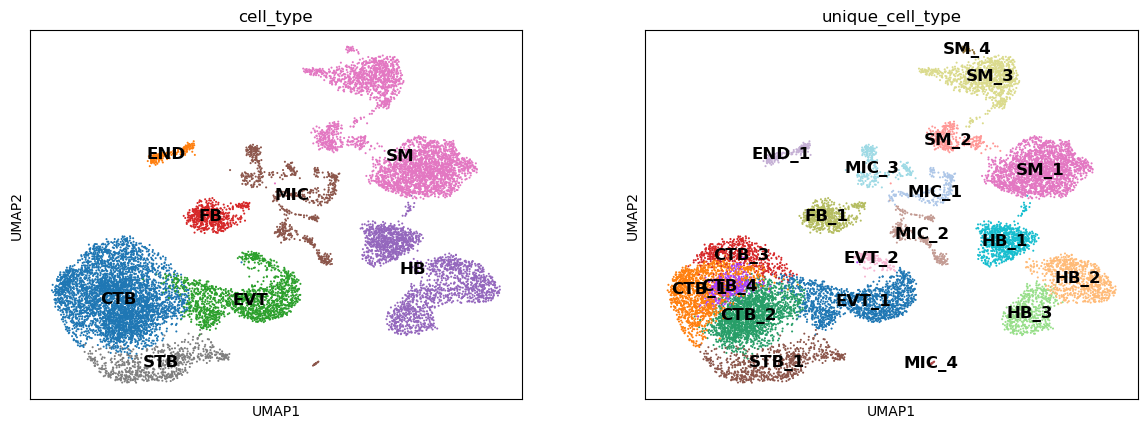

In [22]:
sc.pl.umap(adata, color=['cell_type','unique_cell_type'], legend_loc='on data', legend_fontsize=12)

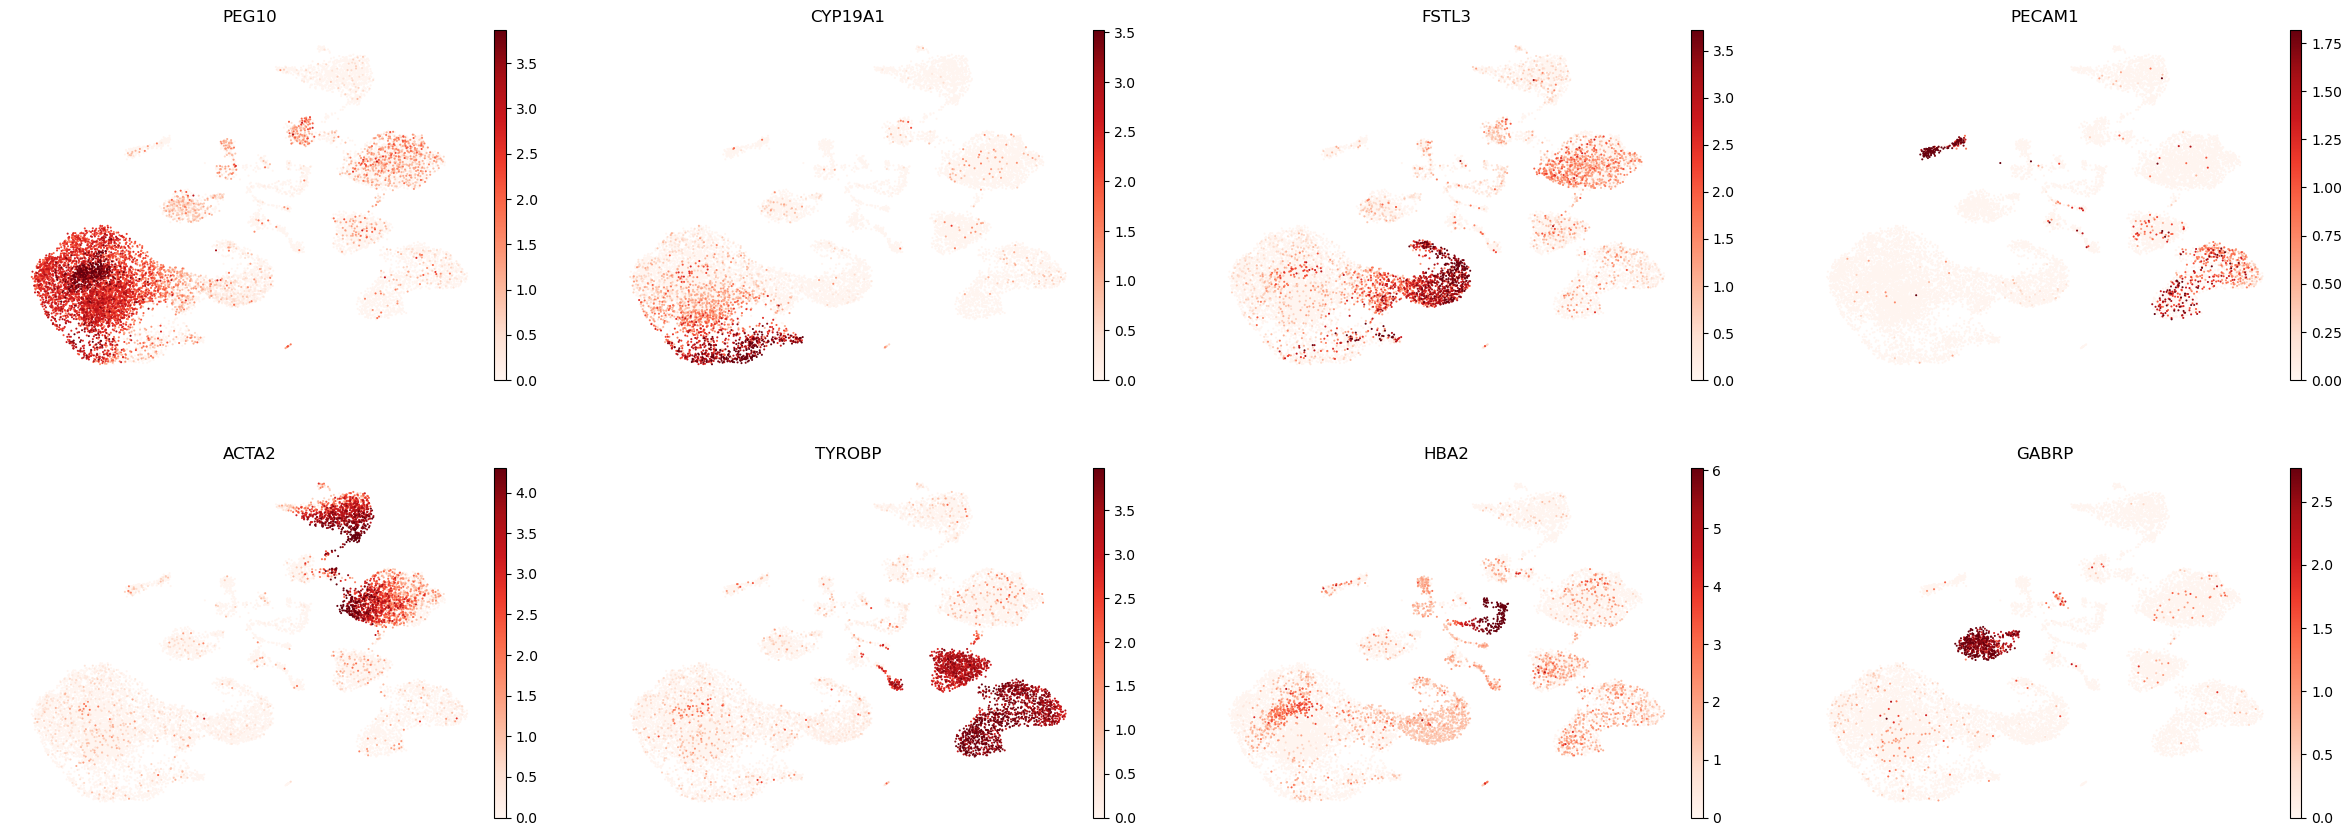

In [23]:
sc.pl.umap(   
    adata,
    color=["PEG10", # "PAGE4" CTB
           "CYP19A1", # STB CELLMARKER2.0
           "FSTL3", # EVT HUMAN PROTEIN ATLAS "HLA-G"
           "PECAM1", # END https://www.frontiersin.org/journals/cardiovascular-medicine/articles/10.3389/fcvm.2019.00165/full
           "ACTA2", # SM PANGLAODB
           "TYROBP", # HB HUMAN PROTEIN ATLAS
           "HBA2", # MIC 
           "GABRP"], # FB HUMAN PROTEIN ATLAS
    vmax="p99",
    legend_loc="on data",
    frameon=False,
    cmap="Reds",
)

In [24]:
adata.write_h5ad('vt_22.04_annotated.h5ad')

In [28]:
mitogenes = pd.read_csv("MitoCarta_genesonly.csv")["Symbol"].tolist()

In [29]:
# Create a boolean column in adata.var for mito_gene
adata.var["mito_gene"] = adata.var_names.str.split(".").str[0].isin(mitogenes)
adata.var

,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mito_gene
Gene,,,,,,,,,,,,,,,
AC145212.1,False,196,0.012093,0.012020,98.832430,203.0,5.318120,196,False,0.011830,0.541032,0.078022,0,False,False
MAFIP,False,16,0.000953,0.000953,99.904688,16.0,2.833213,16,False,0.000700,-0.472424,-1.301019,0,False,False
AC011043.1,False,523,0.033776,0.033218,96.884494,567.0,6.342122,522,False,0.024609,0.291332,-0.249814,0,False,False
AL592183.1,False,355,0.021683,0.021452,97.885268,364.0,5.899898,351,False,0.022753,0.389500,-0.098786,0,False,False
AC240274.1,False,785,0.053732,0.052338,95.323762,902.0,6.805723,783,False,0.040853,0.158105,-0.369524,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMSB4Y,False,277,0.019360,0.019175,98.349914,325.0,5.786897,275,False,0.013771,0.180529,-0.231838,0,False,False
NLGN4Y,False,119,0.007387,0.007360,99.291118,124.0,4.828314,118,False,0.010188,0.379762,0.084606,0,False,False
AC010889.2,False,19,0.001132,0.001131,99.886817,19.0,2.995732,19,False,0.001441,0.447304,0.109962,0,False,False


In [30]:
adata.obs.to_csv("vt_obs.csv")
adata.var.to_csv("vt_var.csv")
adata.to_df().to_csv("vt_X.csv")

# X_df = pd.DataFrame(adata.X, index = adata.obs_names, columns = adata.var_names)
# X_df.to_csv("X.csv")